In [6]:
import cv2
import subprocess
import matplotlib.pyplot as plt
import tempfile
import imageio.v3 as iio
import numpy as np
import os

from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
from scipy.signal import savgol_filter

In [41]:
ROOT = "/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/srp_GX010027-rectified.MP4"
# Find out the proper crop
y1 = 550 #700    # Y1-PADDING cant be lower then 0
y2 = 1700 #1900   # Y2+PADDING cant be bigger then 2160
x1 = 1350 #1500   # X1-PADDING cant be lower then 0
x2 = 2500
samples = 1000


In [42]:
vidcap = cv2.VideoCapture(ROOT)
vidcap.get(cv2.CAP_PROP_FRAME_COUNT)

21528.0

In [43]:
vidcap.set(cv2.CAP_PROP_POS_FRAMES, 3000)
success, frame = vidcap.read()

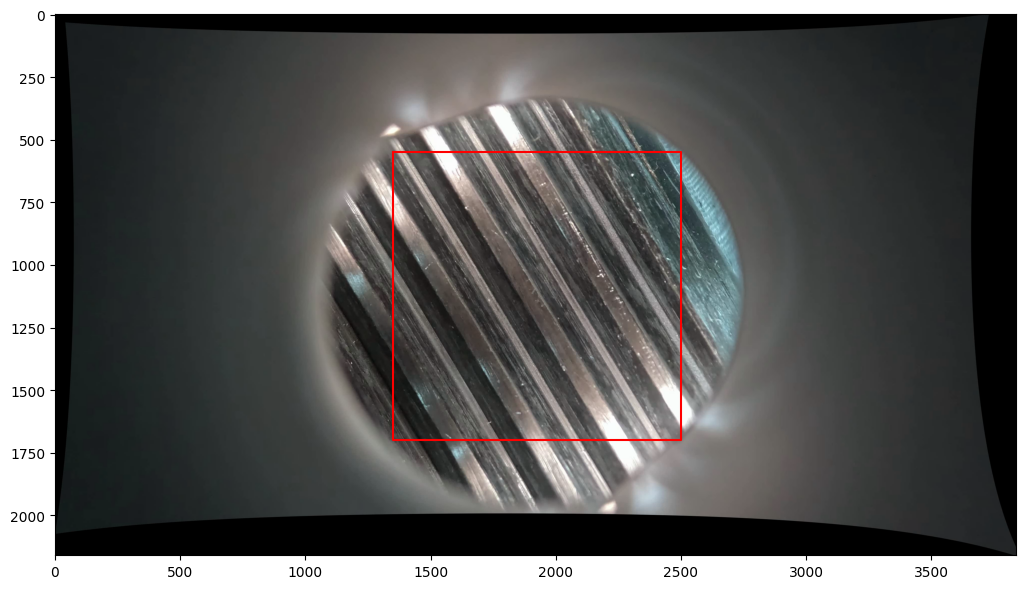

In [44]:
plt.figure(figsize=(18, 6))
# ax = plt.subplot(121)
# ax.imshow(frame[y1:y2, x1:x2,0], cmap="gray")
# ax.set_title('Cropped image')
ax = plt.subplot(111)
ax.imshow(frame)
# ax.set_title('Original Image with the cropping area in red rectangle')
ax.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color="red")
plt.tight_layout()
plt.show()

In [45]:
def unixPathToWinPath(path):
    return path.replace("/mnt/c/", "C:/").replace("/", "\\\\")

def winPathToUnixPath(path):
    return path.replace("\\", "/").replace("C:/", "/mnt/c/")

In [46]:
frame_angles = []
hists = []

vidcap = cv2.VideoCapture(ROOT)

frame_rate = 1

start = 21280
total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames = 56

for i in tqdm(range(21280, start+total_frames, frame_rate),  desc="Processing frames"):
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, i)
    success, frame = vidcap.read()
    undistorted =  frame[y1:y2, x1:x2, 0]
    undistorted = cv2.resize(undistorted, (undistorted.shape[0]//4, undistorted.shape[1]//4))
    otsu_threshold, _ = cv2.threshold(undistorted, 0, 255, cv2.THRESH_OTSU)
    
    with tempfile.NamedTemporaryFile(suffix=".pgm", delete=False) as tmpfile:
        filename = tmpfile.name
        iio.imwrite(tmpfile.name, undistorted)  # this must be a grayscale image
        
        output_path = tmpfile.name.replace(".pgm", ".txt")
        
        process = subprocess.Popen(
            ["wsl", "devernay", winPathToUnixPath(tmpfile.name),
             "-t", winPathToUnixPath(output_path),
             "-l", f"{otsu_threshold / 15}",
             "-h", f"{otsu_threshold / 3}",
             # "-p", f"/mnt/c/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/sample{i}.pdf",
             "-s", f"2"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        tmpfile.close()
        
    # Wait for the process to complete and get stdout and stderr
    stdout, stderr = process.communicate()
    
    # Check for errors in stderr
    if stderr:
        print("Error running devernay:", stderr.decode("utf-8"))
    if os.path.exists(output_path):
        with open(output_path, 'r') as output_file:
            result = output_file.read()
    else:
        print(f"Output file {output_path} does not exist.")

    lines = result.split("\n")
    dev = []
    for line in lines:
        if line != "":
            x, y = line.split(' ')
            dev.append((float(x), float(y)))
    dev = np.array(dev)
    if len(dev) == 0:
        print("Something wrong happen")
    choice = np.random.randint(0, len(dev), samples)
    xx0 = np.matmul(dev[choice, 0].reshape(-1, 1), np.ones((1, len(choice))))
    yy0 = np.matmul(dev[choice, 1].reshape(-1, 1), np.ones((1, len(choice))))
    xx1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 0].reshape(1, -1))
    yy1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 1].reshape(1, -1))
    valid = np.zeros_like(xx0, dtype=bool)
    valid[xx0 != xx1] = 1
    angles = np.zeros_like(xx0, np.float32)
    angles[xx0 == xx1] = np.pi / 2
    angles[valid] = np.arctan((yy0[valid] - yy1[valid]) / (xx0[valid] - xx1[valid])).reshape(-1)
    angles[np.eye(samples, dtype=bool)] = np.nan

    filtered = np.rad2deg(np.abs(angles[~np.isnan(angles)]))

    if filename is not None and os.path.exists(filename):
        os.remove(filename)

    # counts, values = np.histogram(filtered, bins=samples)
    hists.append(filtered)
    # frame_angles.append(values[np.argmax(counts)])

Processing frames: 100%|██████████| 56/56 [00:16<00:00,  3.45it/s]


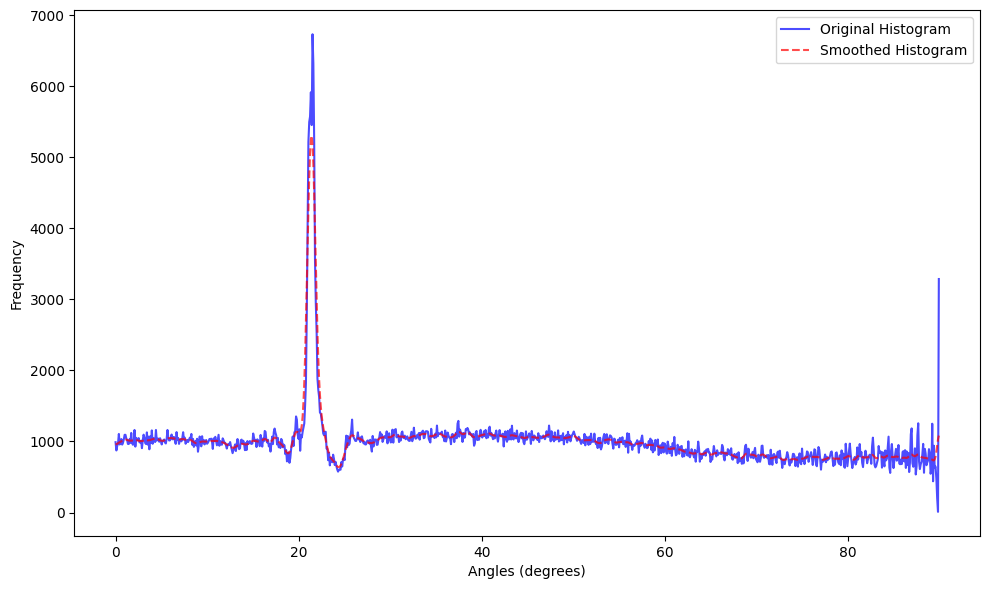

In [13]:
fid = 0
counts, values = np.histogram(hists[fid], bins=samples)
sigma = 3 # Adjust sigma to control the level of smoothing
smoothed_counts = gaussian_filter1d(counts, sigma=sigma)

# Plot the original and smoothed histograms
plt.figure(figsize=(10, 6))
plt.plot(values[:-1], counts, label="Original Histogram", color="blue", alpha=0.7)
plt.plot(values[:-1], smoothed_counts, label="Smoothed Histogram", color="red", linestyle="--", alpha=0.7)
plt.xlabel("Angles (degrees)")  # Add x-axis label
plt.ylabel("Frequency")        # Add y-axis label
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fid = 14
counts, values = np.histogram(hists[fid], bins=samples)
best = values[np.argmax(counts)]
plt.hist(hists[fid], bins=samples)
plt.axvline(best, color="red")
plt.title(best)
plt.show()

In [75]:
frame_angles_smoothed = []
for hist in hists:
    counts, values = np.histogram(hist, bins=samples)
    counts = gaussian_filter1d(counts, sigma=3)
    max_index = np.argmax(counts)
    frame_angles_smoothed.append(values[max_index])

In [15]:
frame_angles_smoothed = np.load("/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/srp_GX010027-full_angles.npy")
total_frames = len(frame_angles_smoothed)
frame_rate = 1

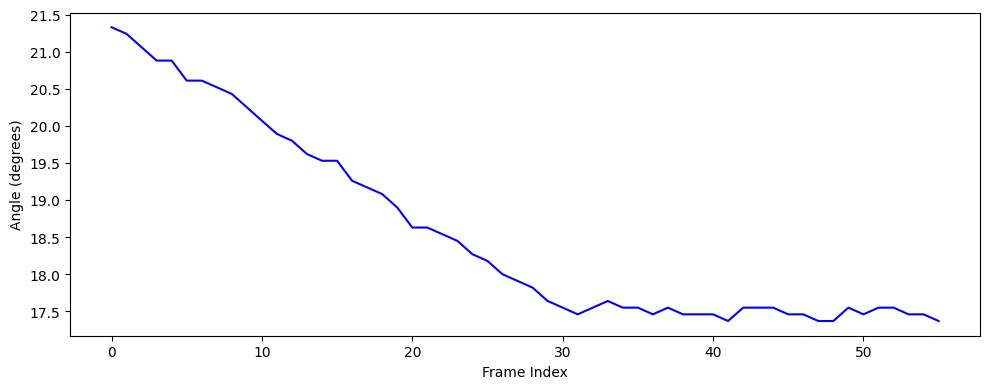

In [48]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(0, total_frames, frame_rate), frame_angles_smoothed, label="Original Histogram", color="blue")
# plt.plot(np.arange(0, total_frames, frame_rate), savgol_filter(frame_angles_smoothed, window_length=8, polyorder=1), label="Smoothed", color="red", linestyle="--", alpha=0.7)
plt.xlabel("Frame Index")  # Add x-axis label
plt.ylabel("Angle (degrees)")  # Add y-axis label
# plt.legend()
plt.tight_layout()
plt.show()


In [103]:
frame_angles_smoothed = savgol_filter(frame_angles_smoothed, window_length=8, polyorder=1)  # Adjust window_length and polyorder based on your data
derivative = np.diff(frame_angles_smoothed)
threshold = frame_rate*0.04 # Adjust this threshold based on your data

segment_type = np.zeros_like(derivative)  # Array to store classification: -1 for decreasing, 0 for constant, 1 for increasing

segment_type[derivative > threshold] = 1  # Increasing
segment_type[derivative < -threshold] = -1  # Decreasing
# Constant parts are already set to 0

# derivative_savgol = np.diff(frame_angles_smoothed_savgol)
# threshold = frame_rate*0.04 # Adjust this threshold based on your data
#
# segment_type_savgol = np.zeros_like(derivative_savgol)  # Array to store classification: -1 for decreasing, 0 for constant, 1 for increasing
#
# segment_type_savgol[derivative_savgol > threshold] = 1  # Increasing
# segment_type_savgol[derivative_savgol < -threshold] = -1  # Decreasing


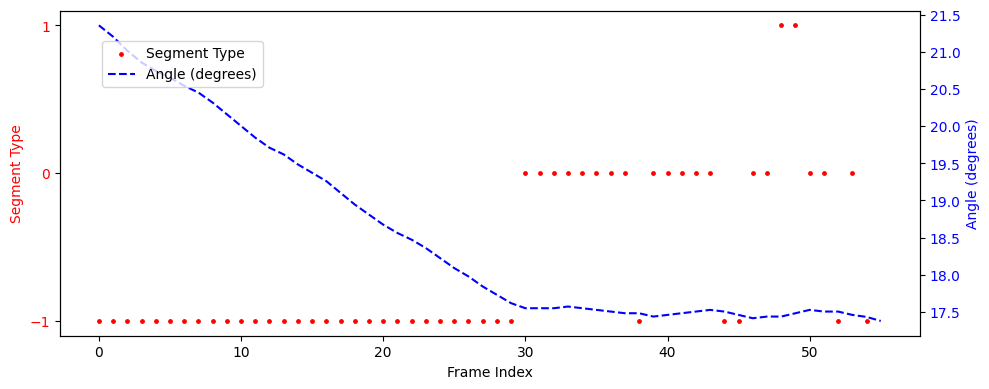

In [62]:
fig, ax1 = plt.subplots(figsize=(10, 4))

# Left Y-axis: Segment Type
ax1.scatter(np.arange(0, total_frames, frame_rate)[:-1], segment_type_savgol,
            label="Segment Type", color="red", s=6)
ax1.set_xlabel("Frame Index")
ax1.set_ylabel("Segment Type", color="red")
ax1.set_yticks([-1, 0, 1])  # Restrict Y-ticks to -1, 0, and 1
ax1.tick_params(axis='y', labelcolor="red")

# Right Y-axis: Angle (degrees)
ax2 = ax1.twinx()  # Create a twin axis sharing the same x-axis
ax2.plot(np.arange(0, total_frames, frame_rate), frame_angles_smoothed_savgol,
         label="Angle (degrees)", color="blue", linestyle="--")
ax2.set_ylabel("Angle (degrees)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

# General plot layout
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()


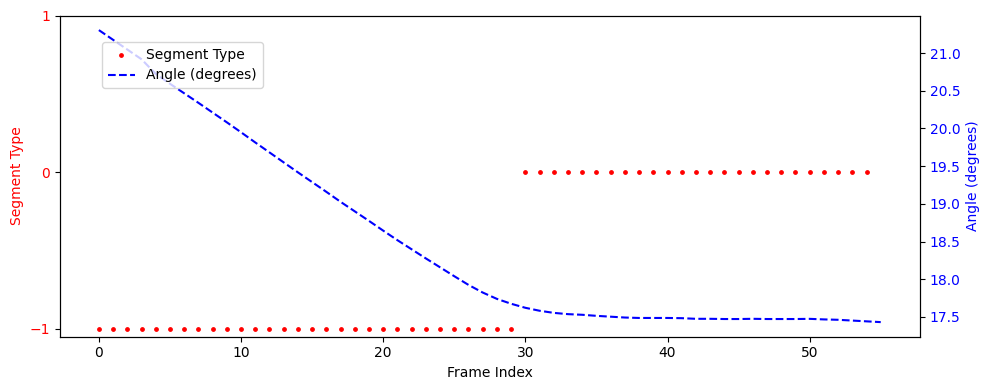

In [104]:
fig, ax1 = plt.subplots(figsize=(10, 4))

# Left Y-axis: Segment Type
ax1.scatter(np.arange(0, total_frames, frame_rate)[:-1], segment_type,
            label="Segment Type", color="red", s=6)
ax1.set_xlabel("Frame Index")
ax1.set_ylabel("Segment Type", color="red")
ax1.set_yticks([-1, 0, 1])  # Restrict Y-ticks to -1, 0, and 1
ax1.tick_params(axis='y', labelcolor="red")

# Right Y-axis: Angle (degrees)
ax2 = ax1.twinx()  # Create a twin axis sharing the same x-axis
ax2.plot(np.arange(0, total_frames, frame_rate), frame_angles_smoothed,
         label="Angle (degrees)", color="blue", linestyle="--")
ax2.set_ylabel("Angle (degrees)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

# plt.axvline(29, color="orange", linestyle="--", alpha=0.7, label="Refined Breakpoint")
# plt.axvline(27, color="green", linestyle="--", alpha=0.7, label="Original Breakpoint")

# General plot layout
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()


In [105]:
breakpoints = np.where(np.diff(segment_type) != 0)[0] + 1  # +1 because np.diff shifts indices by 1
breakpoints = breakpoints * frame_rate

In [106]:
print(breakpoints)

[30]


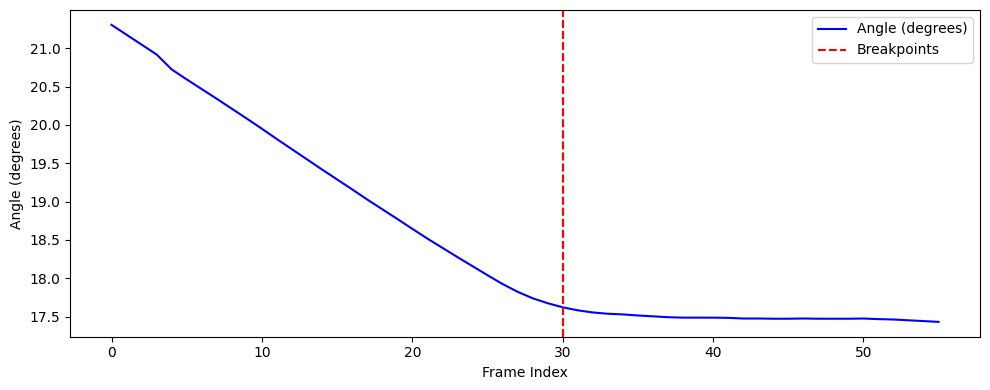

In [107]:
plt.figure(figsize=(10, 4))

# Filter data to include only the first 5000 frames
filtered_indices = np.arange(0, total_frames, frame_rate)
mask = filtered_indices <= 5000

filtered_indices = filtered_indices[mask]
filtered_angles = frame_angles_smoothed[:len(filtered_indices)]

# Plot the smoothed angles
plt.plot(filtered_indices, filtered_angles, label="Angle (degrees)", color="blue")

# Add breakpoints that occur within the first 5000 frames
filtered_breakpoints = [bp for bp in breakpoints if bp <= 5000]
for bp in filtered_breakpoints:
    plt.axvline(bp, color="red", linestyle="--", label="_nolegend_")

# Add a single entry for breakpoints in the legend
if filtered_breakpoints:
    plt.axvline(filtered_breakpoints[0], color="red", linestyle="--", label="Breakpoints")

# Axis labels and title
plt.xlabel("Frame Index")
plt.ylabel("Angle (degrees)")

# Display legend
plt.legend()

plt.tight_layout()
plt.show()


In [99]:
threshold = 1
step = frame_rate
# Define the distance threshold to group close breakpoints

merged_breakpoints = []

# Temporary group for close breakpoints
current_group = [breakpoints[0]]

# Iterate over the breakpoints
for i in range(1, len(breakpoints)):
    # print(breakpoints[i], breakpoints[i - 1], breakpoints[i] - breakpoints[i - 1] <= threshold)
    # If the difference between consecutive breakpoints is below the threshold, group them
    if breakpoints[i] - breakpoints[i - 1] <= threshold:
        current_group.append(breakpoints[i])
    else:
        # If a current group is finished, calculate the rounded average and store it
        avg_breakpoint = int(round(np.mean(current_group)))
        merged_breakpoints.append(avg_breakpoint)
        # Start a new group
        current_group = [breakpoints[i]]

# Handle the last group
if current_group:
    avg_breakpoint = int(round(np.mean(current_group)))
    merged_breakpoints.append(avg_breakpoint)

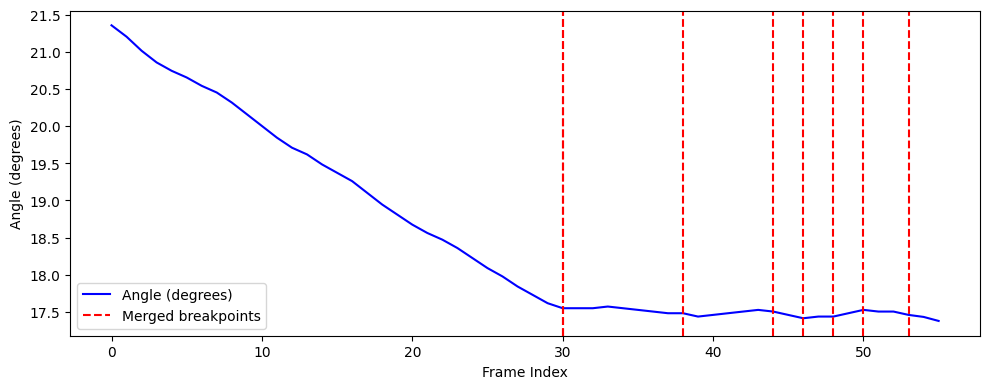

In [100]:
plt.figure(figsize=(10, 4))

# Filter data to include only the first 5000 frames
filtered_indices = np.arange(0, total_frames, frame_rate)
mask = filtered_indices <= 5000

filtered_indices = filtered_indices[mask]
filtered_angles = frame_angles_smoothed[:len(filtered_indices)]

# Plot the smoothed angles
plt.plot(filtered_indices, filtered_angles, label="Angle (degrees)", color="blue")

# Add breakpoints that occur within the first 5000 frames
filtered_breakpoints = [bp for bp in merged_breakpoints if bp <= 5000]
for bp in filtered_breakpoints:
    plt.axvline(bp, color="red", linestyle="--", label="_nolegend_")

# Add a single entry for breakpoints in the legend
if filtered_breakpoints:
    plt.axvline(filtered_breakpoints[0], color="red", linestyle="--", label="Merged breakpoints")

# Axis labels and title
plt.xlabel("Frame Index")
plt.ylabel("Angle (degrees)")

# Display legend
plt.legend()

plt.tight_layout()
plt.show()


In [101]:
new_merged_breakpoints = []
for i in range(len(merged_breakpoints)):
    bp = merged_breakpoints[i]//step
    if stats.mode(segment_type[bp-8:bp])[0] != stats.mode(segment_type[bp:bp+8])[0]:
        new_merged_breakpoints.append(bp)

new_merged_breakpoints = np.concatenate([[0], new_merged_breakpoints, [(len(frame_angles_smoothed) - 1) * step]])


In [86]:
# merged_breakpoints = np.concatenate([[0], merged_breakpoints, [(len(frame_angles_smoothed) - 1) * step]])

if len(merged_breakpoints) > 1:
    if stats.mode(segment_type[:merged_breakpoints[0]//step])[0] == stats.mode(segment_type[merged_breakpoints[0]//step:merged_breakpoints[1]//step])[0]:
        new_merged_breakpoints = []
    else:
        new_merged_breakpoints = [merged_breakpoints[0]]

    for i in range(1, len(merged_breakpoints) - 1):
        # print(i, stats.mode(self.segment_type[merged_breakpoints[i - 1]:merged_breakpoints[i]])[0], stats.mode(self.segment_type[merged_breakpoints[i]:merged_breakpoints[i + 1]])[0])
        if not stats.mode(segment_type[merged_breakpoints[i - 1]//step:merged_breakpoints[i]//step])[0] == stats.mode(segment_type[merged_breakpoints[i]//step:merged_breakpoints[i + 1]//step])[0]:
            new_merged_breakpoints.append(merged_breakpoints[i])

    if not stats.mode(segment_type[merged_breakpoints[-1]//step:])[0] == stats.mode(segment_type[merged_breakpoints[-2]//step:merged_breakpoints[-1]//step])[0]:
        new_merged_breakpoints.append(merged_breakpoints[-1])

new_merged_breakpoints = np.concatenate([[0], new_merged_breakpoints, [(len(frame_angles_smoothed) - 1) * step]])
# Now merged_breakpoints contains the final list of unique breakpoints
print("Merged Breakpoints:", new_merged_breakpoints)


Merged Breakpoints: [ 0 30 44 46 48 50 53 55]


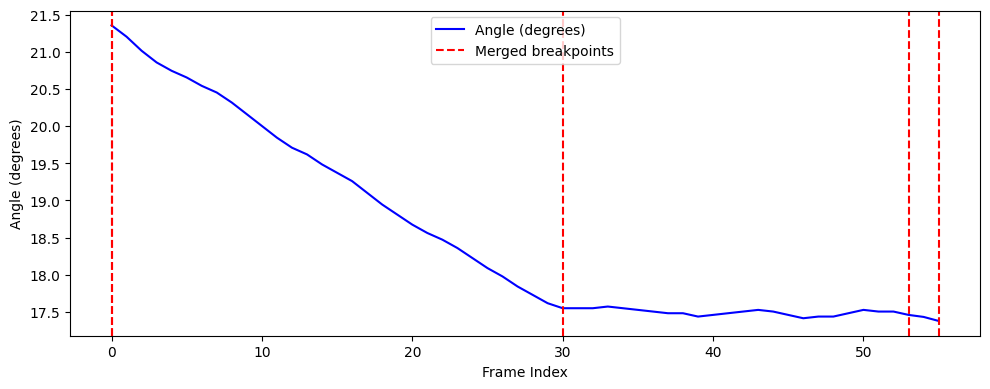

In [102]:
plt.figure(figsize=(10, 4))

# Filter data to include only the first 5000 frames
filtered_indices = np.arange(0, total_frames, frame_rate)
mask = filtered_indices <= 500000

filtered_indices = filtered_indices[mask]
filtered_angles = frame_angles_smoothed[:len(filtered_indices)]

# Plot the smoothed angles
plt.plot(filtered_indices, filtered_angles, label="Angle (degrees)", color="blue")

# Add breakpoints that occur within the first 5000 frames
filtered_breakpoints = [bp for bp in new_merged_breakpoints if bp <= 500000]
for bp in filtered_breakpoints:
    plt.axvline(bp, color="red", linestyle="--", label="_nolegend_")

# Add a single entry for breakpoints in the legend
if filtered_breakpoints:
    plt.axvline(filtered_breakpoints[0], color="red", linestyle="--", label="Merged breakpoints")

# Axis labels and title
plt.xlabel("Frame Index")
plt.ylabel("Angle (degrees)")

# Display legend
plt.legend()

plt.tight_layout()
plt.show()


In [97]:
zero_ratios = []
for i in range(len(new_merged_breakpoints) - 1):
    zero_ratio = np.count_nonzero(segment_type[new_merged_breakpoints[i]:new_merged_breakpoints[i+1]] == 0) / (new_merged_breakpoints[i+1] - new_merged_breakpoints[i])
    zero_ratios.append(zero_ratio)

In [98]:
zero_ratios

[np.float64(0.0), np.float64(0.7391304347826086), np.float64(0.5)]

In [101]:
borderBreakpoints = []
for i in range(0, len(new_merged_breakpoints) - 1):
    if stats.mode(segment_type[new_merged_breakpoints[i] // step:new_merged_breakpoints[i + 1] // step])[0] == 0:
        borderBreakpoints.append([new_merged_breakpoints[i], new_merged_breakpoints[i + 1]])

print(f"Calculated: Border Breakpoints\n"
      f"{np.asarray(borderBreakpoints)}\n")

Calculated: Border Breakpoints
[[    0    26]
 [ 3012  3644]
 [ 6630  7289]
 [10277 11021]
 [14008 14695]
 [17682 18325]
 [21312 21528]]



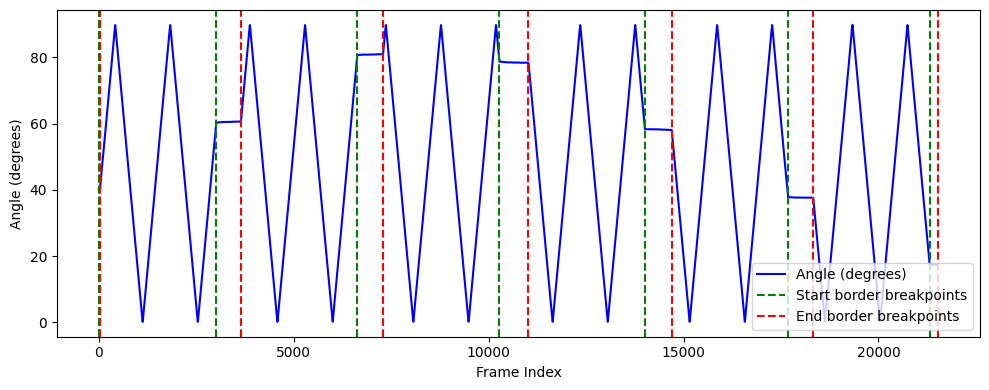

In [102]:
plt.figure(figsize=(10, 4))

# Filter data to include only the first 5000 frames
filtered_indices = np.arange(0, total_frames, frame_rate)
mask = filtered_indices <= 500000

filtered_indices = filtered_indices[mask]
filtered_angles = frame_angles_smoothed[:len(filtered_indices)]

# Plot the smoothed angles
plt.plot(filtered_indices, filtered_angles, label="Angle (degrees)", color="blue")

# Add breakpoints that occur within the first 5000 frames
filtered_breakpoints = [(start, end) for start, end in borderBreakpoints if end <= 500000]
for start, end in filtered_breakpoints:
    plt.axvline(start, color="green", linestyle="--", label="_nolegend_")
    plt.axvline(end, color="red", linestyle="--", label="_nolegend_")

# Add a single entry for breakpoints in the legend
if filtered_breakpoints:
    plt.axvline(filtered_breakpoints[0][0], color="green", linestyle="--", label="Start border breakpoints")
    plt.axvline(filtered_breakpoints[0][1], color="red", linestyle="--", label="End border breakpoints")

# Axis labels and title
plt.xlabel("Frame Index")
plt.ylabel("Angle (degrees)")

# Display legend
plt.legend()

plt.tight_layout()
plt.show()

In [88]:
breakpoints = np.array([0, 8, 10, 12])
segment_type = np.array([-1, -1 ,-1 ,-1 ,-1 ,-1, -1 ,-1, 0,0,0, 1,1])

In [89]:
np.count_nonzero(segment_type[breakpoints[1]:breakpoints[2]] == 0)

2

In [90]:
zero_ratios = []
for i in range(len(breakpoints) - 1):
    zero_ratio = np.count_nonzero(segment_type[breakpoints[i]:breakpoints[i+1]] == 0) / (breakpoints[i+1] - breakpoints[i])
    zero_ratios.append(zero_ratio)

In [16]:
zero_ratios

[np.float64(0.0), np.float64(1.0), np.float64(0.5)]

In [18]:
breakpoints[np.argmax(zero_ratios)]

np.int64(8)

In [21]:
np.max(frame_angles_smoothed)

np.float32(89.91)

In [22]:
frame_angles_smoothed[3090:3100]

array([40.140003, 39.960003, 39.870003, 39.690002, 39.600002, 39.510002,
       39.33    , 39.15    , 39.06    , 38.88    ], dtype=float32)

In [23]:
np.where(np.array(frame_angles_smoothed)==np.min(frame_angles_smoothed))

(array([  577,   578,   579,   580,   581,   582,  1997,  1998,  1999,
         2000,  2001,  4722,  4739,  4753,  4763,  4862,  4863,  4864,
         4865,  4866,  4867,  4868,  6282,  6283,  6284,  6285,  6286,
         7687,  7688,  7689,  7690,  7691,  7692,  7693, 11109, 11110,
        11111, 11112, 11113, 12516, 12517, 12518, 12519, 12520, 15202,
        15203, 15204, 15205, 15206, 15207, 16610, 16611, 16612, 16613,
        16614]),)

In [24]:
np.where(np.array(frame_angles_smoothed)==np.max(frame_angles_smoothed))

(array([  247,   248,   249,   250,   251,   252,   253,   254,   255,
          256,   257,   258,   259,   260,   261,   262,   263,  1276,
         1277,  1278,  1279,  1280,  1281,  1282,  1283,  2698,  2699,
         2700,  2701,  2702,  4723,  4724,  4725,  4726,  4727,  4728,
         4729,  4730,  4731,  4732,  4733,  4734,  4735,  4736,  4737,
         4738,  4740,  4741,  4742,  4743,  4744,  4745,  4746,  4747,
         4748,  4749,  4750,  4751,  4752,  4754,  4755,  4756,  4757,
         4758,  4759,  4760,  4761,  4762,  5572,  5573,  5574,  5575,
         5576,  5577,  5578,  6990,  6991,  6992,  6993,  6994,  6995,
        10401, 10402, 10403, 10404, 10405, 11816, 11817, 11818, 11819,
        11820, 14492, 14493, 14494, 14495, 14496, 15906, 15907, 15908,
        15909, 15910]),)

In [81]:
new_merged_breakpoints

array([    0,    26,   419,  1124,  1830,  2539,  3013,  3645,  3874,
        4582,  5290,  5998,  6631,  7290,  7362,  8068,  8776,  9485,
       10188, 10278, 11022, 11642, 12348, 13055, 13760, 14008, 14696,
       15155, 15861, 16572, 17272, 17682, 18325, 18626, 19319, 19323,
       19332, 20042, 20744, 21312, 21528])

1 1 0 0
2 1 1 -180
3 1 1 -180
4 1 2 -360
5 1 2 -360
7 2 2 -360
8 2 3 -540
9 2 3 -540
10 2 4 -720
11 2 4 -720
13 3 4 -720
14 3 5 -900
15 3 5 -900
16 3 6 -1080
17 3 6 -1080
18 3 7 -1260
20 4 7 -1260
21 4 7 -1260
22 4 8 -1440
23 4 8 -1440
24 4 9 -1620
26 5 9 -1620
27 5 9 -1620
28 5 10 -1800
29 5 10 -1800
30 5 11 -1980
32 6 11 -1980
33 6 11 -1980
34 6 12 -2160
35 6 12 -2160
36 6 13 -2340


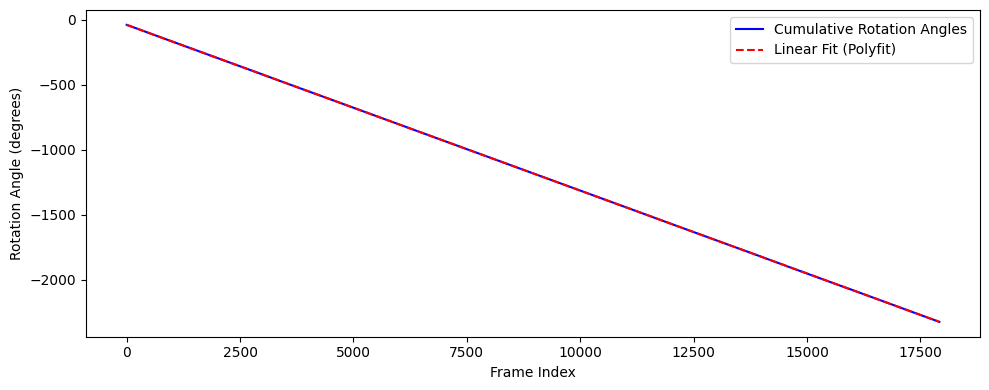

Calculated : RotationPerFrame
0.12733326507113527


In [104]:
fa = []
j = 0
k = 0
start, end = borderBreakpoints[j]
for i in range(0, len(new_merged_breakpoints)-1):
# for i in range(0, 14):
    if not start == new_merged_breakpoints[i]:
        segment = stats.mode(segment_type[new_merged_breakpoints[i]:new_merged_breakpoints[i + 1]])[0]
        offset = -(k * 180)
        print(i, j, k, offset)
        if segment == 1 and not start == new_merged_breakpoints[i+1]:
            k += 1
        f = frame_angles_smoothed[new_merged_breakpoints[i]:new_merged_breakpoints[i + 1]] * -segment + offset
        fa = np.concatenate([fa, f])
    else:
        j += 1
        if j < len(borderBreakpoints):
            start, end = borderBreakpoints[j]

a, b = np.polyfit(np.arange(len(fa)), fa, 1)

plt.figure(figsize=(10, 4))
plt.plot(fa, label="Cumulative Rotation Angles", color="blue")
plt.plot([(a * x + b) for x in np.arange(len(fa))], label="Linear Fit (Polyfit)", color="red", linestyle="--")
plt.xlabel("Frame Index")
plt.ylabel("Rotation Angle (degrees)")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

print(f"Calculated : RotationPerFrame\n"
      f"{-a}")

In [ ]:
# fa = np.concatenate([frame_angles_smoothed[96:488], -frame_angles_smoothed[488:1198], -180 + frame_angles_smoothed[1198: 1895], -180 - frame_angles_smoothed[1895: 2603], -360 + frame_angles_smoothed[2603: 3095]])
a, b = np.polyfit(np.arange(len(fa)), fa, 1)

In [ ]:
plt.plot(fa)
plt.plot([(a*x + b) for x in np.arange(len(fa))])
plt.show()

In [ ]:
rot = -a
angle = -rot*(487-98)
rotated = []

vidcap = cv2.VideoCapture(ROOT)

# total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames = 3095-98

success, frame = vidcap.read()

vidcap.set(cv2.CAP_PROP_POS_FRAMES, 98)

out = cv2.VideoWriter('/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/output.mp4', 
                      apiPreference=cv2.CAP_FFMPEG,
                      fourcc=cv2.VideoWriter_fourcc(*'h264'),
                      fps=20.0,
                      frameSize=(y2-y1, x2-x1),
                        params=[
                            cv2.VIDEOWRITER_PROP_DEPTH,
                            cv2.CV_8U,
                            cv2.VIDEOWRITER_PROP_IS_COLOR,
                            0,  # false
                        ]
                      )

for i in tqdm(range(total_frames), desc="Processing frames"):
    success, frame = vidcap.read()
    rotate_matrix = cv2.getRotationMatrix2D((frame.shape[1]/2, frame.shape[0]/2), angle, 1)    
    rotated_image = cv2.warpAffine( 
        src=frame, M=rotate_matrix, dsize=(frame.shape[1], frame.shape[0]))[y1: y2, x1:x2, 0]
    
    out.write(rotated_image.astype(np.uint8))
    
    angle += rot
    
out.release()

In [ ]:
# Define the codec and create VideoWriter object
#out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))
out = cv2.VideoWriter('/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/output.mp4', 
                      apiPreference=cv2.CAP_FFMPEG,
                      fourcc=cv2.VideoWriter_fourcc(*"H264"),
                      fps=10.0,
                      frameSize=(rotated[0].shape[1], rotated[0].shape[0]),
                        params=[
                            cv2.VIDEOWRITER_PROP_DEPTH,
                            cv2.CV_8U,
                            cv2.VIDEOWRITER_PROP_IS_COLOR,
                            0,  # false
                        ])
for frame in tqdm(rotated):
    out.write(frame.astype(np.uint8))
out.release()


In [ ]:
plt.figure(figsize=(15, 8))
ax = plt.subplot(121)
ax.imshow(rotated[10], cmap="gray")
ax = plt.subplot(122)
ax.imshow(rotated[200], cmap="gray")
plt.show()

In [ ]:
np.max(rotated)

In [ ]:
rot

In [1]:
def invert_intervals_and_filter(breakpoints, total_range, threshold_ratio=0.5):
    start, end = total_range
    inverted = []

    # Step 1: Generate inverted intervals
    if breakpoints[0][0] > start:
        inverted.append([start, breakpoints[0][0] - 1])

    for i in range(1, len(breakpoints)):
        inverted.append([breakpoints[i - 1][1] + 1, breakpoints[i][0] - 1])

    if breakpoints[-1][1] < end:
        inverted.append([breakpoints[-1][1] + 1, end])

    # Step 2: Calculate average size of intervals
    sizes = [interval[1] - interval[0] + 1 for interval in inverted]
    avg_size = sum(sizes) / len(sizes)

    # Step 3: Define a threshold
    threshold = threshold_ratio * avg_size

    # Step 4: Filter first and last intervals if they are below the threshold
    if len(inverted) > 1 and (inverted[0][1] - inverted[0][0] + 1) < threshold:
        inverted.pop(0)
    if len(inverted) > 1 and (inverted[-1][1] - inverted[-1][0] + 1) < threshold:
        inverted.pop(-1)

    return inverted

In [2]:

# Example usage
breakpoints = [[3012, 3644], [6631, 7290], [10278, 11021], [14009, 14695], [17682, 18325], [21313, 21528]]
total_range = [0, 22000]  # Adjust total range as needed
filtered_intervals = invert_intervals_and_filter(breakpoints, total_range)
print(filtered_intervals)


[[0, 3011], [3645, 6630], [7291, 10277], [11022, 14008], [14696, 17681], [18326, 21312]]


In [6]:
def getInvertedIntervals(intervals):
    return np.array([[intervals[i - 1][1], intervals[i][0]] for i in range(1, len(intervals))])

In [7]:
getInvertedIntervals(filtered_intervals)

array([[ 3011,  3645],
       [ 6630,  7291],
       [10277, 11022],
       [14008, 14696],
       [17681, 18326]])

In [8]:
sizes = [interval[1] - interval[0] + 1 for interval in filtered_intervals]
sum(sizes) / len(sizes)

2990.8333333333335